# Análisis de segmentación de clientes

**Marbin del C. Seca G.**

# Introducción

En este proyecto, segmentaremos a los clientes mediante la agrupación de K-Medias de un conjunto de datos de clientes de centros comerciales. 

# Carga y Procesamiento de datos

Importamos las librerias esenciales

In [3]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

Leemos los datos desde el archivo CSV. La carga de datos es el primer paso crucial en cualquier análisis.

Para predecir el comportamiento de los consumidores, se usará la fuente de datos (dataset) 
Mall_Customers.csv, puede ser bajada de la ruta https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-Python  

El dataset consta de los siguientes campos: 
1. CustomerID: Identificación del cliente. 
2. Gender: Genero del cliente. 
3. Age: Edad del cliente. 
4. AnnualIncome: Ingresos anuales del cliente. 
5. SpendingScore: Puntuación del gasto, valor entre 1 y 100, que indica cuánto ha gastado un cliente 
en el centro comercial; cuanto más valor, más puntaje. 


In [4]:
datos = pl.read_csv("Mall_Customers.csv")

In [5]:
datos.head()

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
i64,str,i64,i64,i64
1,"""Male""",19,15,39
2,"""Male""",21,15,81
3,"""Female""",20,16,6
4,"""Female""",23,16,77
5,"""Female""",31,17,40


In [6]:
datos.tail()

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
i64,str,i64,i64,i64
196,"""Female""",35,120,79
197,"""Female""",45,126,28
198,"""Male""",32,126,74
199,"""Male""",32,137,18
200,"""Male""",30,137,83


In [7]:
datos.shape

(200, 5)

In [8]:
datos.glimpse()

Rows: 200
Columns: 5
$ CustomerID             <i64> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
$ Gender                 <str> 'Male', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female', 'Female', 'Male', 'Female'
$ Age                    <i64> 19, 21, 20, 23, 31, 22, 35, 23, 64, 30
$ Annual Income (k$)     <i64> 15, 15, 16, 16, 17, 17, 18, 18, 19, 19
$ Spending Score (1-100) <i64> 39, 81, 6, 77, 40, 76, 6, 94, 3, 72



In [9]:
datos.null_count()

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
u32,u32,u32,u32,u32
0,0,0,0,0


In [10]:
datos.describe()

statistic,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
str,f64,str,f64,f64,f64
"""count""",200.0,"""200""",200.0,200.0,200.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",100.5,null,38.85,60.56,50.2
"""std""",57.879185,null,13.969007,26.264721,25.823522
"""min""",1.0,"""Female""",18.0,15.0,1.0
"""25%""",51.0,null,29.0,42.0,35.0
"""50%""",101.0,null,36.0,62.0,50.0
"""75%""",150.0,null,49.0,78.0,73.0
"""max""",200.0,"""Male""",70.0,137.0,99.0


In [11]:

datos_num = datos[["CustomerID","Age","Annual Income (k$)","Spending Score (1-100)"]]
datos_num 

CustomerID,Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64,i64
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
…,…,…,…
196,35,120,79
197,45,126,28
198,32,126,74


In [12]:
datos_num.corr()

CustomerID,Age,Annual Income (k$),Spending Score (1-100)
f64,f64,f64,f64
1.0,-0.026763,0.977548,0.013835
-0.026763,1.0,-0.012398,-0.327227
0.977548,-0.012398,1.0,0.009903
0.013835,-0.327227,0.009903,1.0


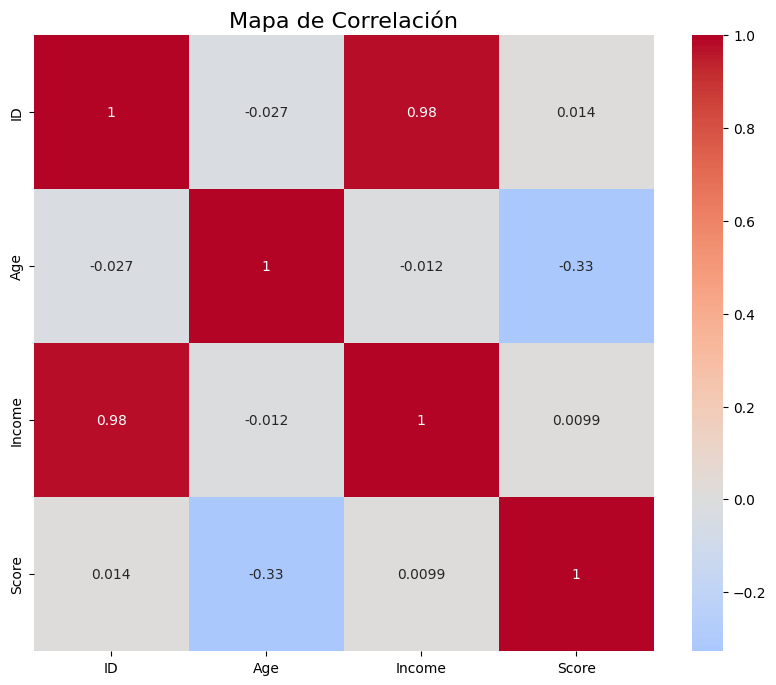

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(datos_num.corr(), annot=True, cmap='coolwarm', center=0,
            xticklabels=['ID', 'Age', 'Income', 'Score'],
            yticklabels=['ID', 'Age', 'Income', 'Score'])
plt.title('Mapa de Correlación', fontsize=16)
plt.show()

Como existe relación espurea entre la varible CostumerID y Annual Income, procedemos a retirar la variable CostumerID para obtener una mejor correlacion entre variables

In [14]:
datos_num = datos[["Age","Annual Income (k$)","Spending Score (1-100)"]]
datos_num

Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64
19,15,39
21,15,81
20,16,6
23,16,77
31,17,40
…,…,…
35,120,79
45,126,28
32,126,74


In [15]:
datos_num.corr()

Age,Annual Income (k$),Spending Score (1-100)
f64,f64,f64
1.0,-0.012398,-0.327227
-0.012398,1.0,0.009903
-0.327227,0.009903,1.0


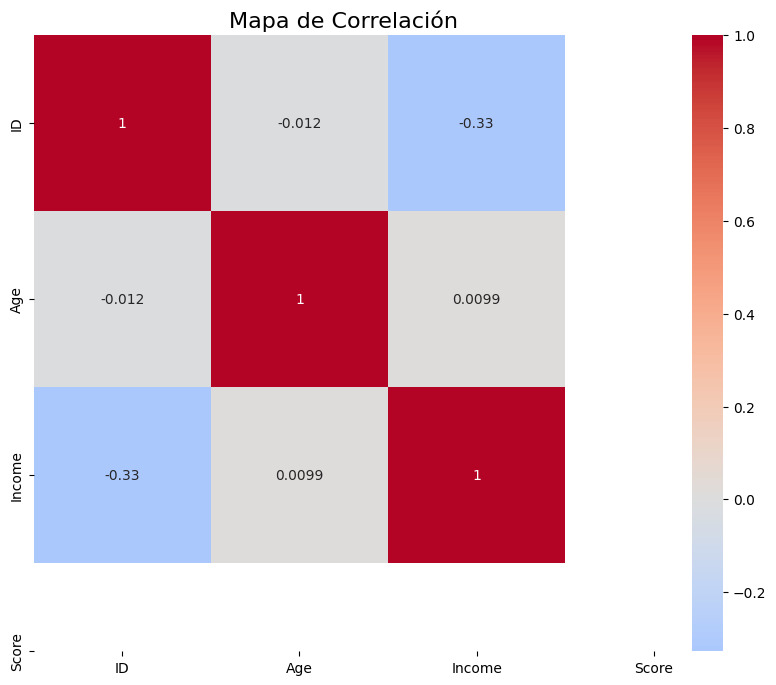

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(datos_num.corr(), annot=True, cmap='coolwarm', center=0,
            xticklabels=['ID', 'Age', 'Income', 'Score'],
            yticklabels=['ID', 'Age', 'Income', 'Score'])
plt.title('Mapa de Correlación', fontsize=16)
plt.show()

### Distribución anual del ingreso

Text(0, 0.5, 'Cantidad')

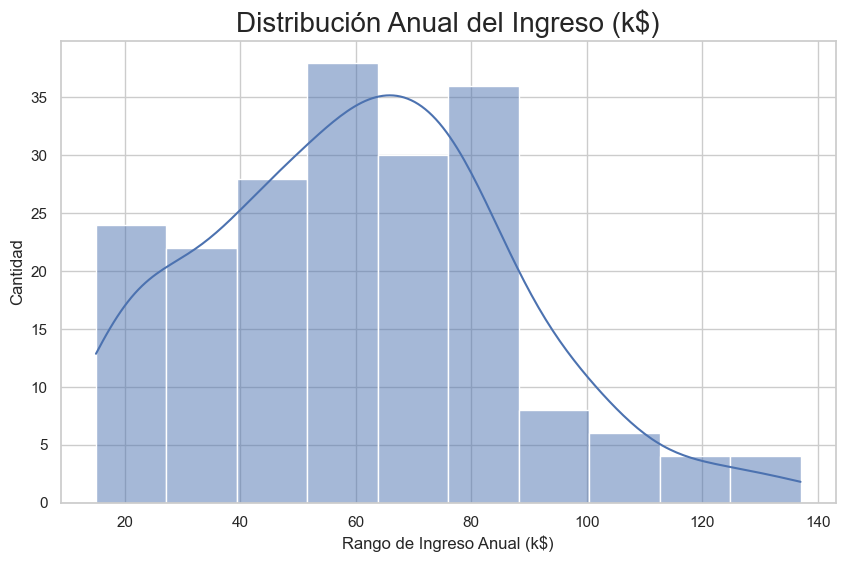

In [17]:
plt.figure(figsize=(10, 6))
sns.set_theme(style = 'whitegrid')
sns.histplot(datos['Annual Income (k$)'], kde=True)
plt.title('Distribución Anual del Ingreso (k$)', fontsize = 20)
plt.xlabel('Rango de Ingreso Anual (k$)')
plt.ylabel('Cantidad')

La mayor parte del ingreso anual oscila entre 50.000 y 85.000 dólares.

### Distribución por edad

Text(0, 0.5, 'Cantidad')

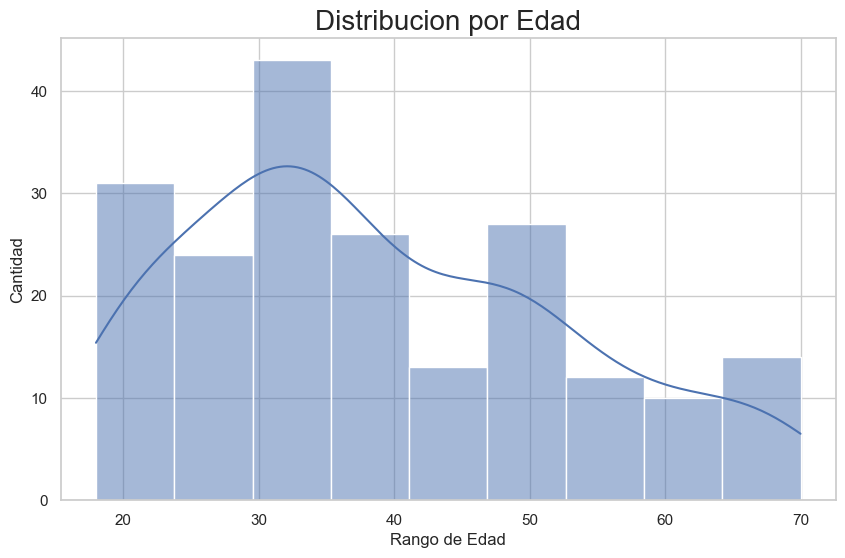

In [18]:
plt.figure(figsize=(10, 6))
sns.set_theme(style = 'whitegrid')
sns.histplot(datos['Age'], kde=True)
plt.title('Distribucion por Edad', fontsize = 20)
plt.xlabel('Rango de Edad')
plt.ylabel('Cantidad')

Hay clientes de una amplia variedad de edades.

### Distribucion del score asignado

Text(0, 0.5, 'Cantidad')

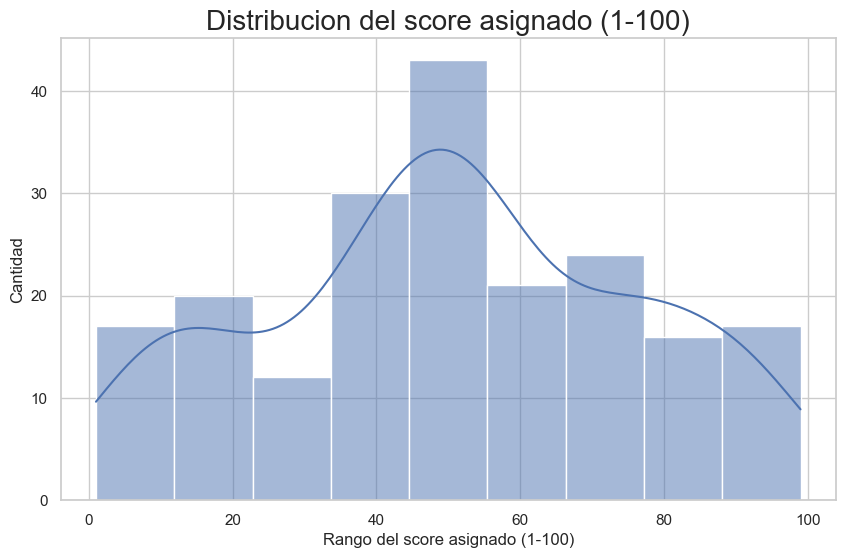

In [19]:
plt.figure(figsize=(10, 6))
sns.set_theme(style = 'whitegrid')
sns.histplot(datos['Spending Score (1-100)'], kde=True)
plt.title('Distribucion del score asignado (1-100)', fontsize = 20)
plt.xlabel('Rango del score asignado (1-100)')
plt.ylabel('Cantidad')

La puntuación máxima de gasto está en el rango de 40 a 60.

### Analisis de Genero

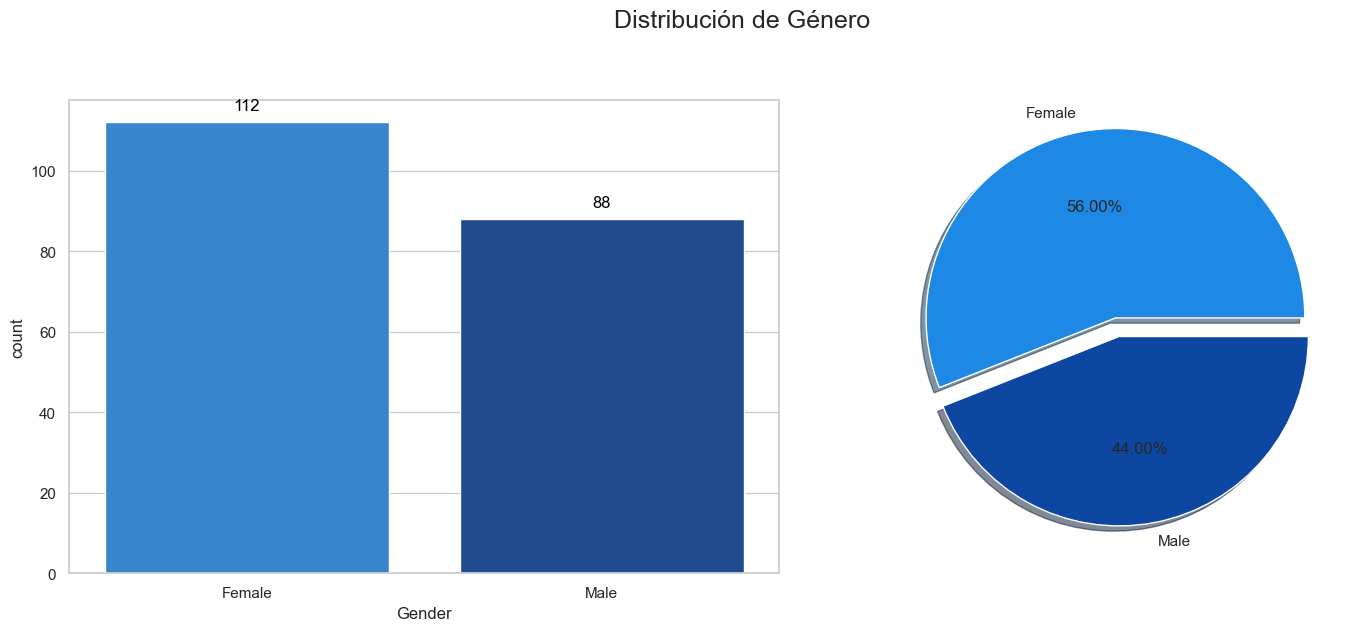

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


colors = {'Female': '#1E88E5', 'Male': '#0D47A1'}  

# Bar plot
genders = datos['Gender'].value_counts().sort('Gender')
bars = sns.barplot(x=genders["Gender"], 
                  y=genders["count"], 
                  hue=genders["Gender"],
                  palette=colors.values(),
                  legend=False, 
                  ax=ax1)
for i, count in enumerate(genders['count']):
    ax1.text(i, count + 3, str(count), ha='center', color='black')

# Pie chart
labels = genders['Gender'].to_list()
sizes = genders['count'].to_list()
colors_list = [colors[gender] for gender in labels]

ax2.pie(sizes, 
        colors=colors_list, 
        explode=[0.1, 0], 
        labels=labels, 
        shadow=True, 
        autopct='%.2f%%')

fig.suptitle('Distribución de Género', fontsize=18, y=1.05)

plt.tight_layout()
plt.show()

Mirando el gráfico circular anterior que explica sobre la distribución de Género en el Centro Comercial. Curiosamente, Las Mujeres están a la cabeza con una participación del 56%, mientras que los Hombres tienen una participación del 44%, eso es una gran brecha, especialmente cuando la población de Hombres es comparativamente más alta que las Mujeres.

### Relación entre las variables del Dataset

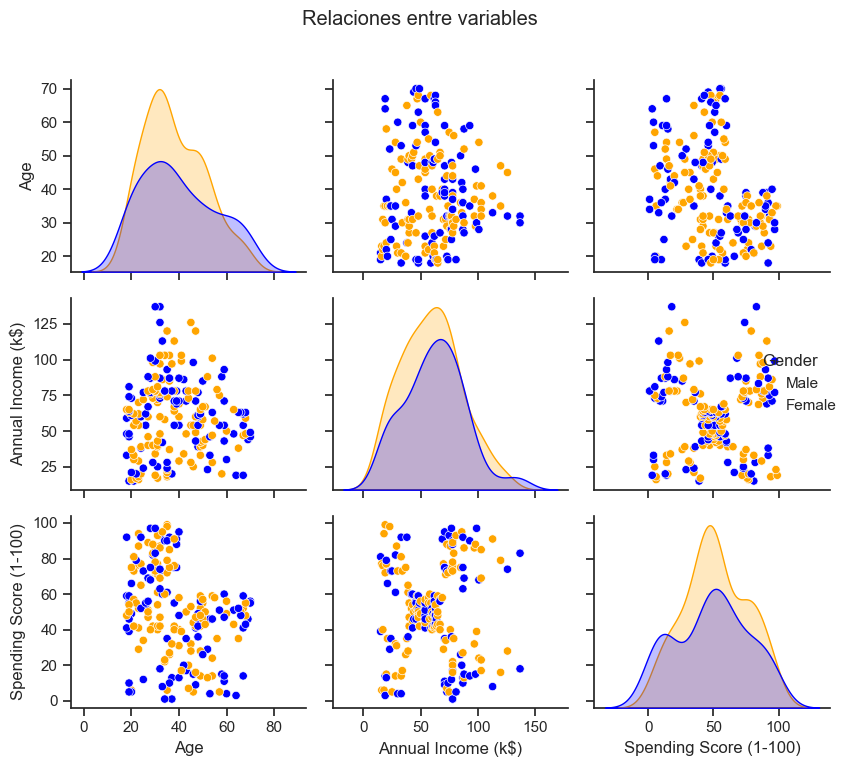

In [21]:
sns.set_theme(style="ticks")
pair_plot = sns.pairplot(datos.to_pandas(), 
                        vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
                        hue='Gender',
                        palette=['blue', 'orange'],
                        diag_kind='kde')

plt.suptitle('Relaciones entre variables', y=1.02)
plt.tight_layout()


### Análisis del pairplot

1. Correlaciones por edad:
- Correlación débil negativa con Ingreso Anual (-0.12) 
- Correlación débil negativa con Score Asignado (-0.33)
- La edad tiene poca influencia en los patrones de ingresos y gastos

2. Relaciones con Ingreso Anual:
- No hay correlación significativa con Score Asignado (0.01)
- Distribución relativamente uniforme entre grupos de edad
- Mayores ingresos concentrados en clientes de mediana edad

3. Patrones de Score Asignado:
- No muestra correlación fuerte con edad, ni ingresos
- Alta variabilidad en todos los grupos de edad y niveles de ingreso  
- Sugiere que el comportamiento de gasto es independiente de factores demográficos

4. Diferencias por género:
- Clientes femeninos muestran scores de gasto ligeramente más altos
- Distribución de ingresos similar entre géneros
- Distribución de edad balanceada entre géneros

5. Características de las distribuciones:
- Edad muestra distribución normal centrada entre 35-45 años
- Ingresos con ligero sesgo a la derecha indicando algunos valores atípicos altos
- Scores de gasto aproximadamente distribuidos normalmente

Este análisis sugiere que los segmentos de clientes no están claramente definidos por variables individuales, respaldando la necesidad de análisis de clusters para identificar grupos significativos de clientes.

#### Edad vs Ingreso Anual

<Axes: title={'center': 'Edad vs Ingreso Anual'}, xlabel='Age', ylabel='Annual Income (k$)'>

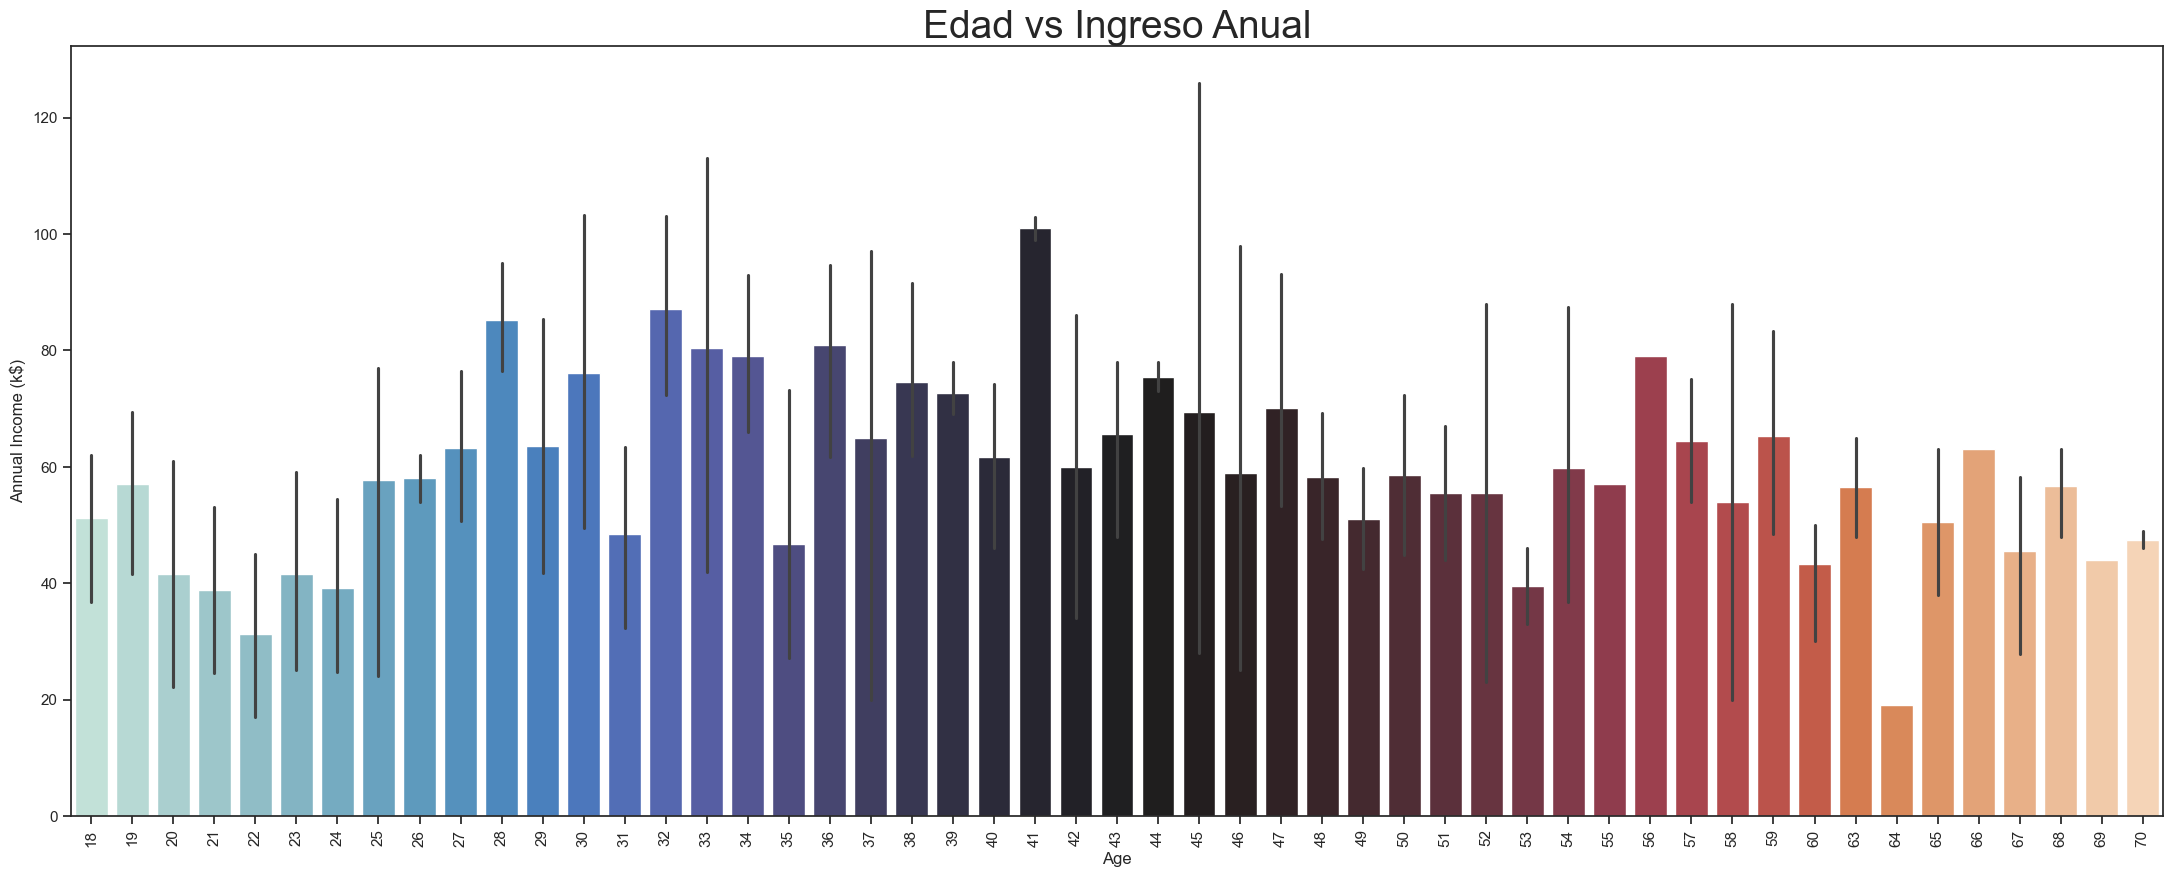

In [22]:
plt.figure(figsize=(27,10))
plt.title('Edad vs Ingreso Anual', fontsize = 28)
plt.xticks(rotation=90)
sns.barplot(x=datos['Age'], y=datos['Annual Income (k$)'], hue=datos['Age'], legend=False, palette='icefire') 

El ingreso anual es máximo a la edad de 33 y 42 años.

#### Edad vs Score Asignado

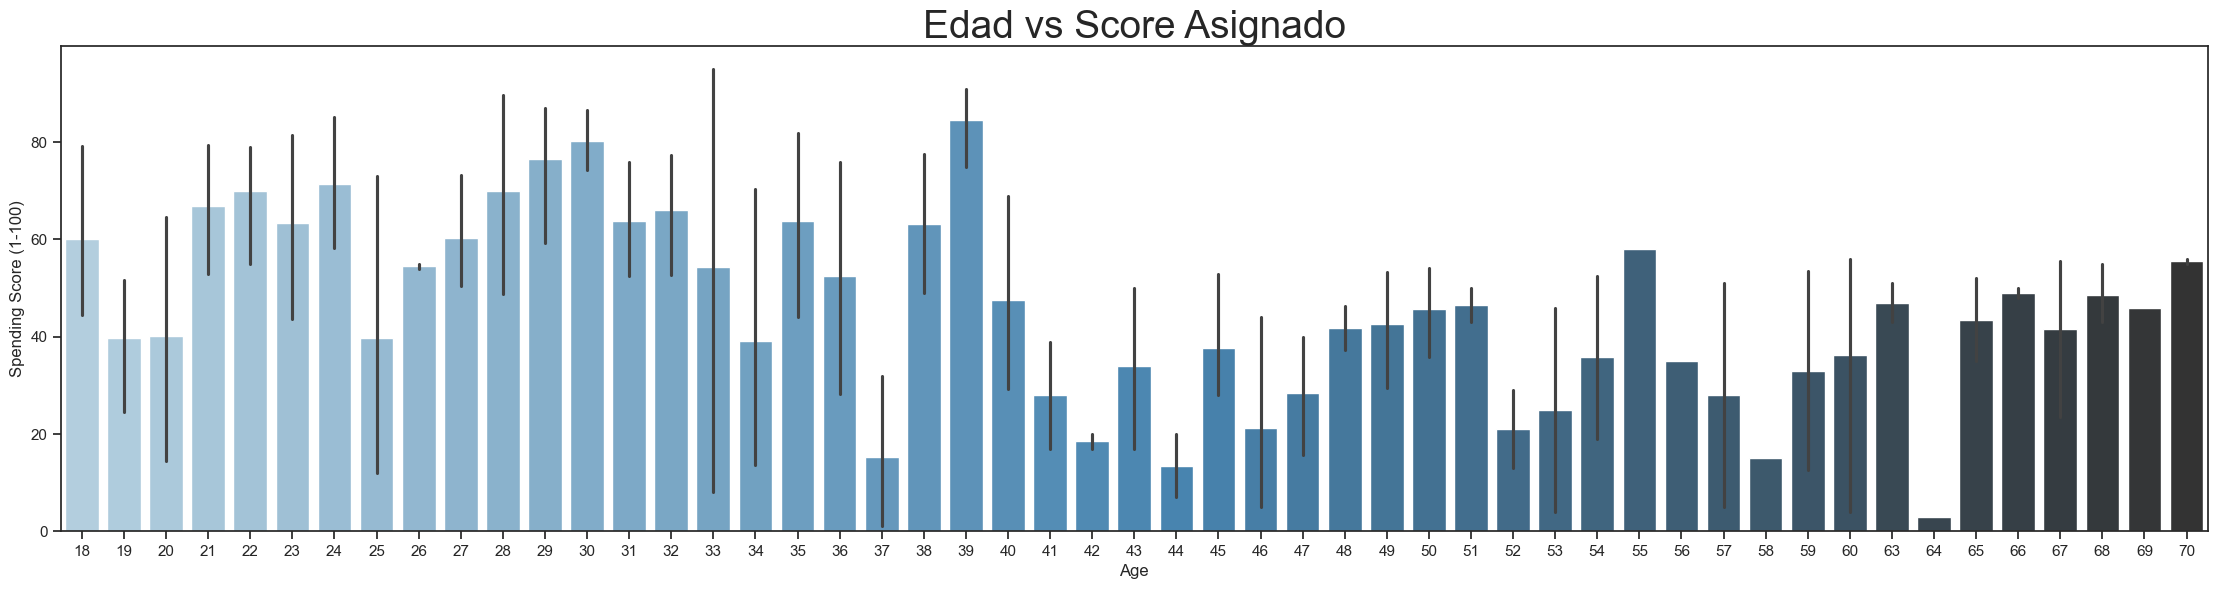

In [23]:
plt.figure(figsize=(27.7, 6.30))
plt.title('Edad vs Score Asignado', fontsize = 28)
ax = sns.barplot(x="Age", y="Spending Score (1-100)", data=datos, hue="Age", legend=False, palette="Blues_d")
sns.set_context("poster")

Podemos observar que, la edad entre 28 y 39 años obtiene el puntaje máximo de gasto y la razón detrás de esto es que su ingreso anual es muy alto.

#### Genero vs Score Asignado

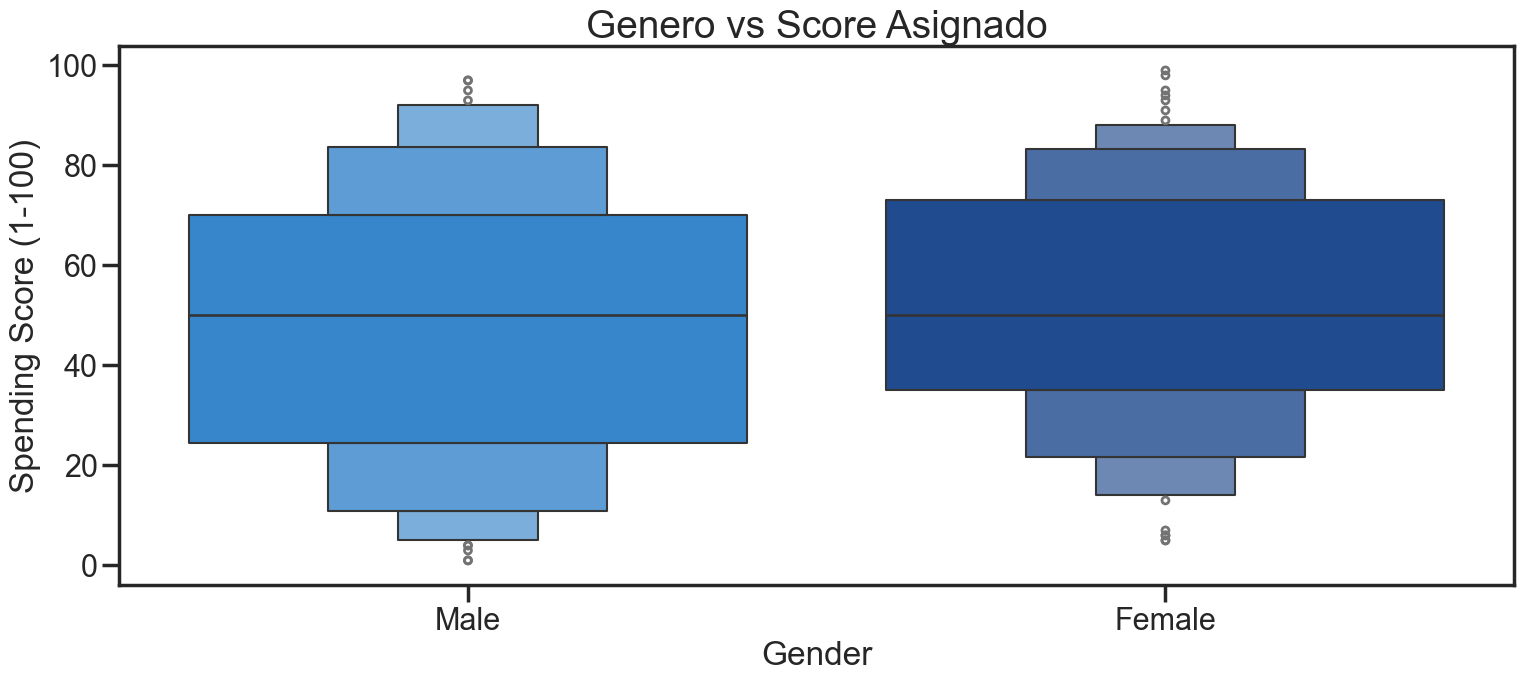

In [24]:
plt.rcParams['figure.figsize'] = (18, 7)
fig, ax = plt.subplots()

# Use a blue color palette for the boxenplot
sns.boxenplot(x='Gender', y='Spending Score (1-100)', data=datos, hue='Gender', palette=['#1E88E5', '#0D47A1'], legend=False)
plt.title('Genero vs Score Asignado', fontsize=28)
plt.show()

Es claramente visible que la mayoría de los hombres tienen una Puntuación de Gasto de alrededor de 25.000 a 70.000 dólares, mientras que las mujeres tienen una puntuación de gasto de alrededor de 35.000 a 75.000 dólares, que nuevamente señala el hecho de que las mujeres son líderes en compras.

#### Genero vs Ingreso Anual

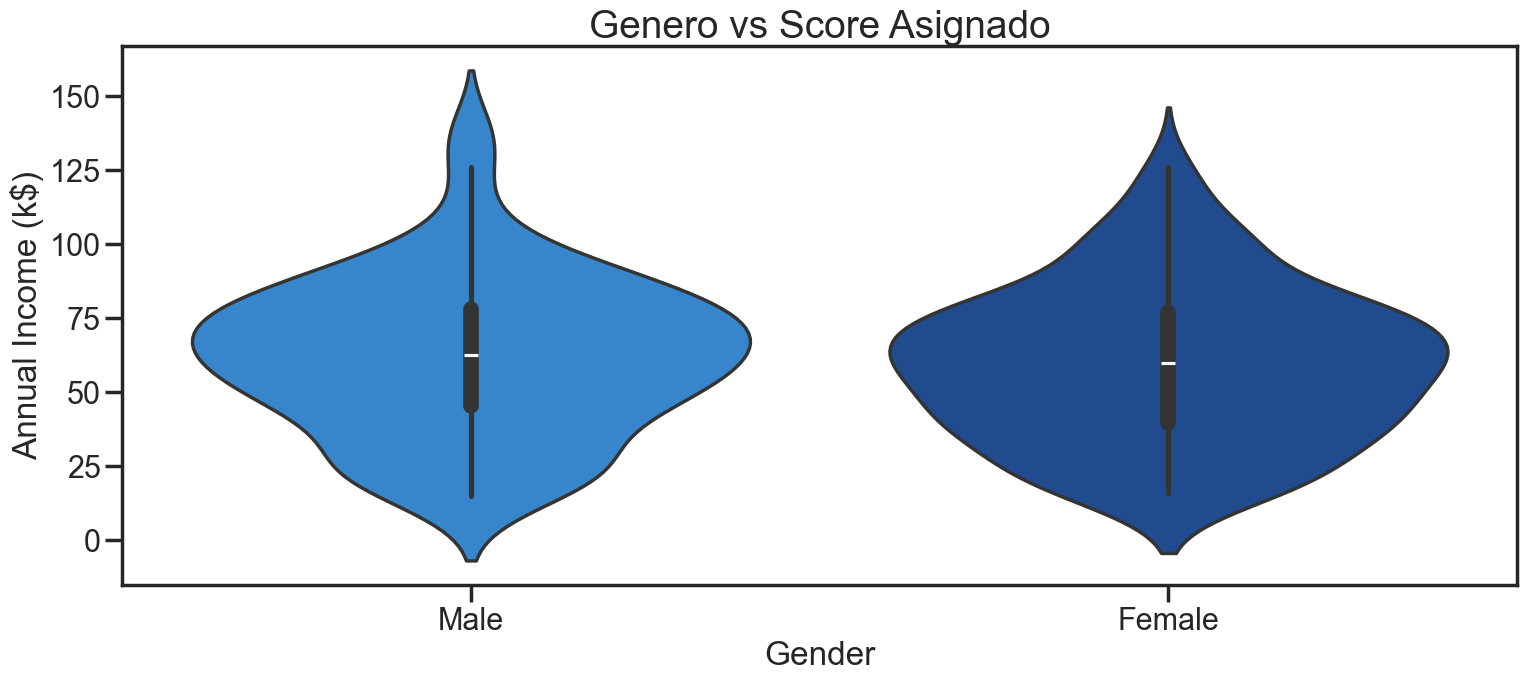

In [25]:
plt.rcParams['figure.figsize'] = (18, 7)
sns.violinplot(x='Gender', y='Annual Income (k$)', data=datos, hue='Gender', palette=['#1E88E5', '#0D47A1'], legend=False)
plt.title('Genero vs Score Asignado', fontsize = 28)
plt.show()

En el gráfico anterior, podemos ver que hay más hombres a los que se les paga más que a las mujeres. Pero, el número de hombres y mujeres es igual en número cuando se trata de bajos ingresos anuales.

## Analísis K-MEANS

### Agrupación en clústeres basada en 2 características.

En primer lugar, trabajamos solo con dos características: Annual income (K$)y Spending Score (1-100). Para ello, seleccionamos dichas columnas del dataset y las convertimos en un ndarray de NumPy, luego, asociamos este resultado a X, siendo esta la famosa matriz de características.

In [26]:
X = datos[["Annual Income (k$)", "Spending Score (1-100)"]].to_numpy()
X[: 5]

array([[15, 39],
       [15, 81],
       [16,  6],
       [16, 77],
       [17, 40]])

Al visualizar estas dos variables en un gráfico de dispersión, obtenemos una primera impresión de la distribución de los clientes. Los datos parecen contener algunos patrones.

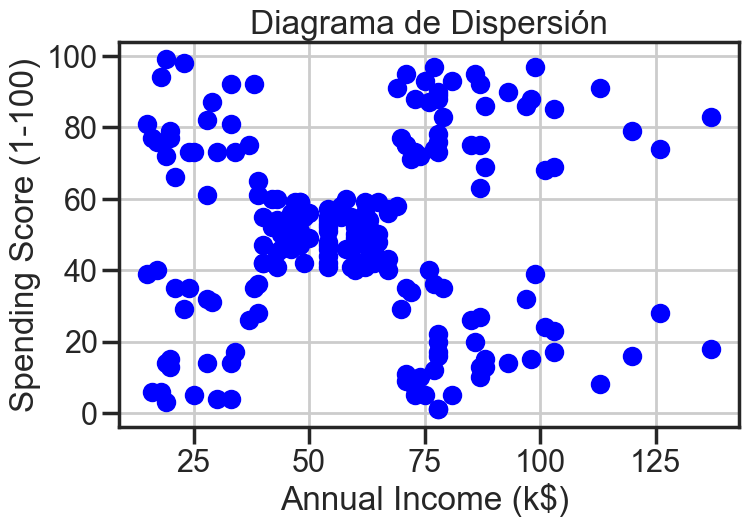

In [27]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], color='blue', marker='o')
plt.title('Diagrama de Dispersión')
plt.xlabel('Annual Income (k$) ')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()

Ahora calculamos la suma de errores cuadrados (WSS) dentro del conglomerado para diferentes valores de k. A continuación, elegimos el k para el cual el WSS comienza a disminuir. Este valor de K nos proporciona el número óptimo de conglomerados para crear a partir de los datos sin procesar.

1. Ejecutar el algoritmo 10 veces: cuando K=1, K=2, … K=10
2. Calcularemos la suma de los cuadrados de cada clusters (WCSS)
3. Visualizaremos en un grafico cuando sucede ese cambio de tendencia mediante la gráfica del codo

In [28]:
wcss = []
n_clu = 10

for i in range(1, n_clu+1):

    kmeans = KMeans(n_clusters = i, 
                    init = "k-means++", 
                    max_iter = 300, 
                    n_init = 10, 
                    random_state = 42)

    kmeans.fit(X) 
    
    wcss.append(kmeans.inertia_)

In [29]:
wcss

[269981.28,
 181363.59595959593,
 106348.37306211122,
 73679.78903948836,
 44448.4554479337,
 37233.814510710006,
 30241.34361793658,
 25036.417604033988,
 21916.79478984373,
 20072.070939404002]

#### Método Elbow: Escogiendo numero óptimo K clústers

Conocido como el gráfico del codo. El eje x representa el número de clústeres. Este número se toma en el punto de articulación del codo. Este punto es donde la formación de clústeres es más relevante, ya que el valor de WCSS deja de disminuir repentinamente. En el gráfico, después de 5, la caída es mínima, por lo que 5 representa el número de clústeres.

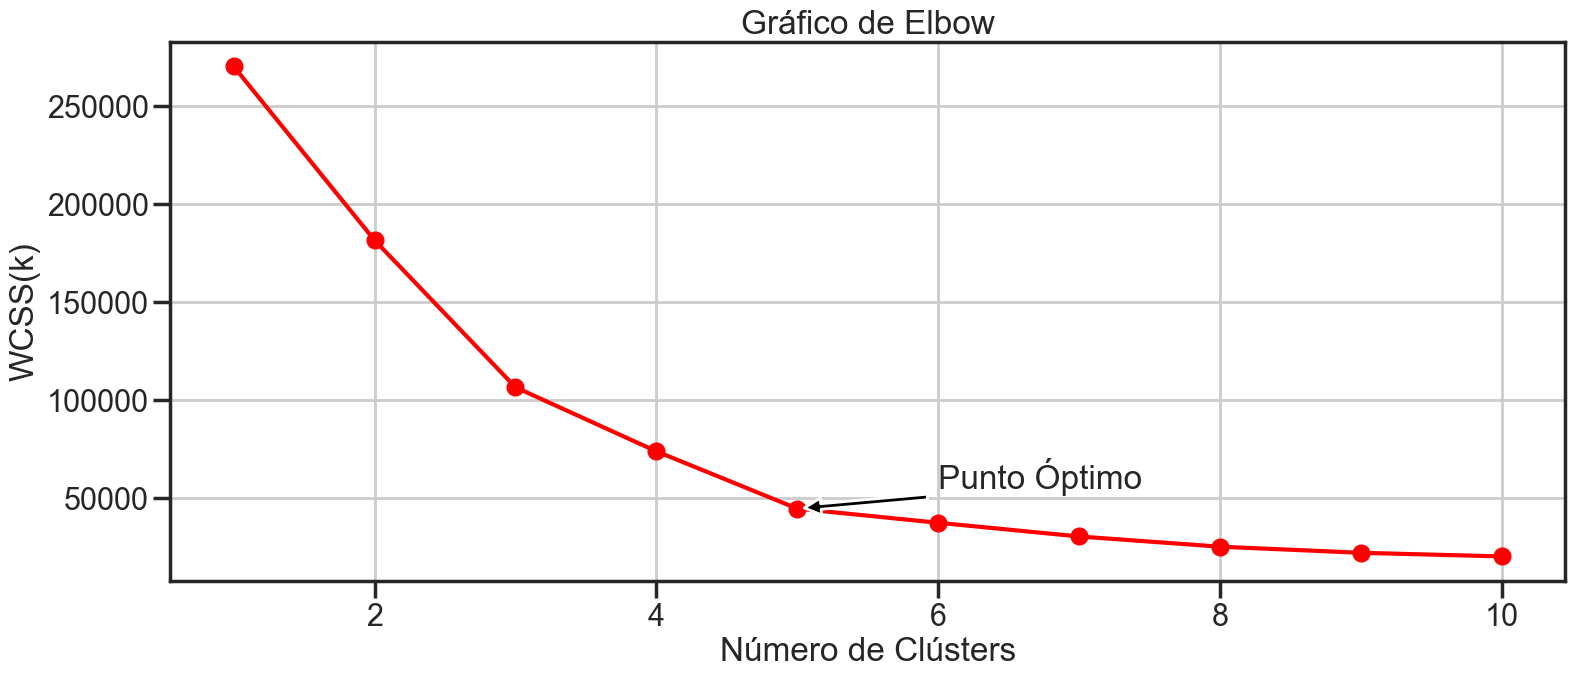

In [30]:
plt.plot(range(1,11), wcss, marker='o', color='red')
plt.title("Gráfico de Elbow")
plt.xlabel("Número de Clústers")
plt.ylabel("WCSS(k)")
plt.grid(True)

# Anotar el punto de codo para una mejor visualización
plt.annotate('Punto Óptimo', xy=(5, wcss[4]), 
             xytext=(6, wcss[4]+10000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)

#### El metodo de la Silueta (Silhouette)
El método de la silueta es otra técnica para determinar el número óptimo de clusters.
Este método calcula qué tan similar es un objeto a su propio cluster en comparación con otros clusters. El rango va de -1 a 1, donde:
- Un valor alto (cerca de 1) indica que el objeto está bien emparejado con su cluster
- Un valor cercano a 0 indica que el objeto está en la frontera entre dos clusters
- Un valor negativo indica que el objeto podría estar asignado al cluster equivocado

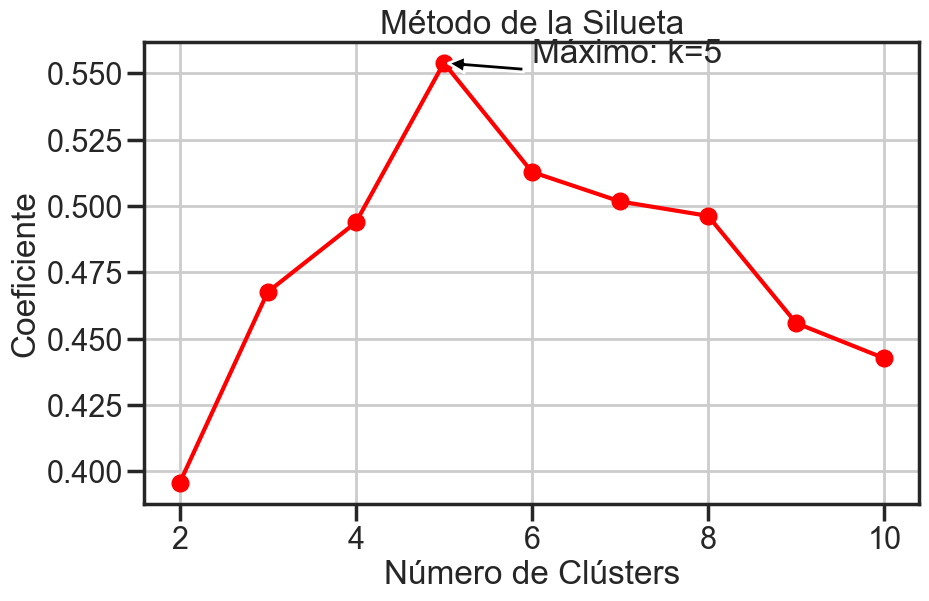

El coeficiente de silueta más alto se obtiene con k = 5
Valor del coeficiente: 0.5539


In [31]:
# Calculamos el coeficiente de la silueta para diferentes valores de k
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o', color='red')
plt.xlabel('Número de Clústers')
plt.ylabel('Coeficiente')
plt.title('Método de la Silueta')
plt.grid(True)

# Anotamos el valor máximo
k_optimo = K[silhouette_scores.index(max(silhouette_scores))]
plt.annotate(f'Máximo: k={k_optimo}', 
            xy=(k_optimo, max(silhouette_scores)),
            xytext=(k_optimo+1, max(silhouette_scores)),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

print(f"El coeficiente de silueta más alto se obtiene con k = {k_optimo}")
print(f"Valor del coeficiente: {max(silhouette_scores):.4f}")


Teniendo ya el K-óptimo, lo que vamos hacer es organizar nuestro dataset X en 5 grupos o clústeres distintos.

La idea, es volver a ejecutar el método K-means con K=5 para que el algoritmo encuentre las mejores 5 agrupaciones basándonos en las características de los datos.

In [32]:
kmeans = KMeans(n_clusters = 5, 
                init="k-means++", 
                max_iter = 100, 
                n_init = 10, 
                random_state = 42)
           
y_kmeans = kmeans.fit_predict(X)


Mostramos las 10 primeras observaciones en los clústeres:

In [33]:
y_kmeans[0:10]

array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2], dtype=int32)

Este DataFrame ampliado, X_clustered, nos permite examinar no solo las características originales de cada muestra, sino también su asignación a un clúster específico, abriendo un camino hacia un análisis detallado y contextualizado de los grupos identificados.

In [34]:
y_kmeans_series = pl.Series(name='Cluster Pred', values=y_kmeans)

X_clustered = datos.with_columns(y_kmeans_series)
X_clustered

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster Pred
i64,str,i64,i64,i64,i32
1,"""Male""",19,15,39,4
2,"""Male""",21,15,81,2
3,"""Female""",20,16,6,4
4,"""Female""",23,16,77,2
5,"""Female""",31,17,40,4
…,…,…,…,…,…
196,"""Female""",35,120,79,1
197,"""Female""",45,126,28,3
198,"""Male""",32,126,74,1


### Visualización de clústeres y centroides.
Para ello, utilizamos un gráfico de dispersión para representar cada uno de los cinco clústeres identificados por el algoritmo K-Means. Cabe destacar que esto es posible gracias a que solo estamos analizados dos variables.

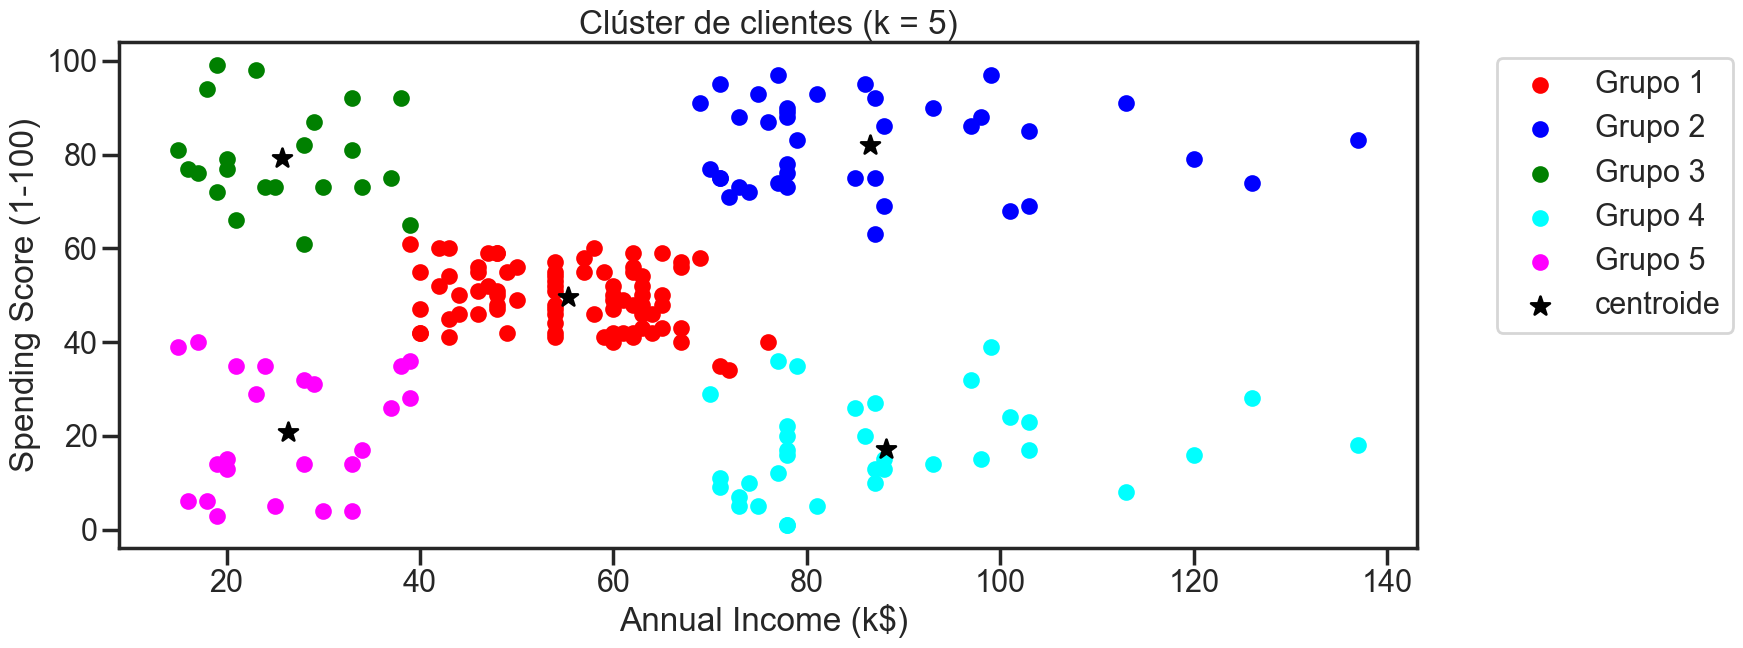

In [35]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], 
              s = 100, c = "red", label = "Grupo 1")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], 
              s = 100, c = "blue", label = "Grupo 2")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, 
              c = "green", label = "Grupo 3")
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, 
              c = "cyan", label = "Grupo 4")
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, 
              c = "magenta", label = "Grupo 5")

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
              s = 200, c = "black", label = "centroide", marker = '*')

plt.title('Clúster de clientes (k = 5)')
plt.xlabel('Annual Income (k$) ')
plt.ylabel('Spending Score (1-100)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Los Puntos Centroides
Representan la posición promedio de los datos asignados a cada grupo y son clave para definir la estructura de la segmentación. Durante el proceso iterativo de K-means, los centroides se recalculan hasta que la agrupación se estabiliza. En resumen, los centroides actúan como referencia para asignar cada dato al clúster más adecuado.


In [36]:
kmeans.cluster_centers_

array([[55.2962963 , 49.51851852],
       [86.53846154, 82.12820513],
       [25.72727273, 79.36363636],
       [88.2       , 17.11428571],
       [26.30434783, 20.91304348]])

Por último, creamos un DataFrame con los CustomerID y sus correspondientes clusters

In [37]:
cluster_ids = X_clustered.select(['CustomerID']).with_columns(pl.Series(name='Cluster Pred', values=y_kmeans))
grouped_ids = cluster_ids.group_by('Cluster Pred').agg(pl.col('CustomerID'))

# Mostrar los clientes en cada cluster
for cluster in range(5):
    print(f"\nCluster {cluster} Customer IDs:")
    print(grouped_ids.filter(pl.col('Cluster Pred') == cluster).select('CustomerID').to_series().to_list())



Cluster 0 Customer IDs:
[[44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 127, 133, 143]]

Cluster 1 Customer IDs:
[[124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200]]

Cluster 2 Customer IDs:
[[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 46]]

Cluster 3 Customer IDs:
[[125, 129, 131, 135, 137, 139, 141, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199]]

Cluster 4 Customer IDs:
[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 3

### Agrupamiento de k-medias basado en datos 3D.

Ahora, trabajaremos con tres tipos de datos. Además del gasto y los ingresos anuales de los clientes, también consideraremos su edad.

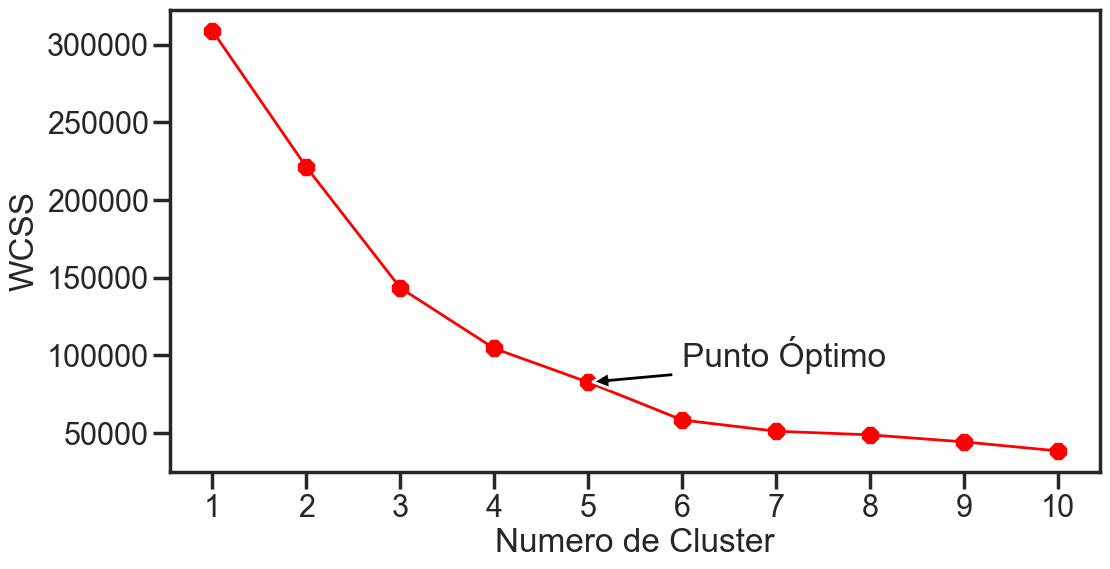

In [38]:
# Tomando las características
X1=datos[["Age","Annual Income (k$)","Spending Score (1-100)"]]
# Ahora calculamos la Suma de Errores Cuadrados dentro del Cluster (WSS) para diferentes valores de k)
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("Numero de Cluster")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")

# Anotar el punto de codo para una mejor visualización
plt.annotate('Punto Óptimo', xy=(5, wcss[4]), 
             xytext=(6, wcss[4]+10000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

La curva WCSS.
Aquí podemos asumir que K=5 será un buen valor.



In [39]:
# Elegimos el k para el cual WSS comienza a disminuir
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(X1)
X1 = X1.with_columns(pl.Series(name="label", values=y))

In [40]:
X1

Age,Annual Income (k$),Spending Score (1-100),label
i64,i64,i64,i32
19,15,39,1
21,15,81,1
20,16,6,3
23,16,77,1
31,17,40,3
…,…,…,…
35,120,79,2
45,126,28,0
32,126,74,2


Visualización de clústeres y centroides.

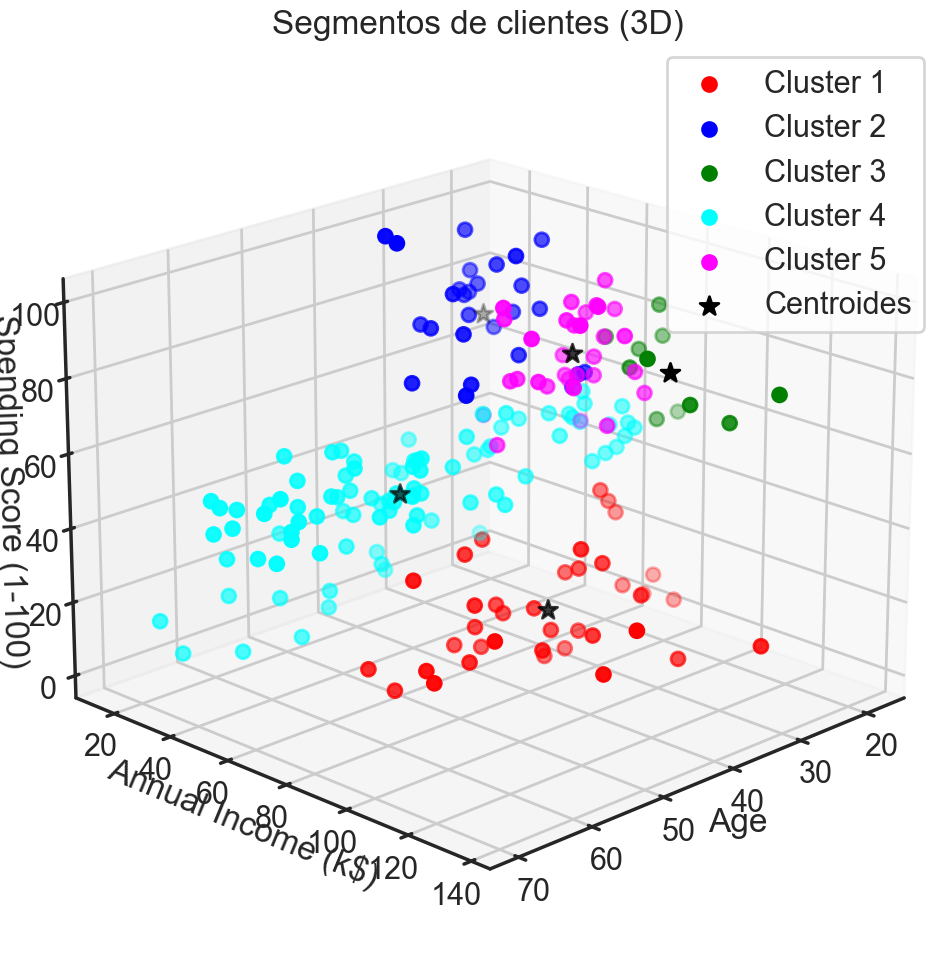

In [41]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.view_init(elev=20, azim=45)  # Ajustar el ángulo de visualización para una mejor visibilidad

# Graficar los puntos para cada clúster
colors = ['red', 'blue', 'green', 'cyan', 'magenta']
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

for i in range(5):
    cluster_points = X1.filter(pl.col('label') == i)
    ax.scatter(cluster_points['Age'],
              cluster_points['Annual Income (k$)'],
              cluster_points['Spending Score (1-100)'],
              c=colors[i],
              label=labels[i],
              s=100)

# Graficar los centroides
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], 
          centroids[:, 1], 
          centroids[:, 2], 
          c='black', 
          marker='*', 
          s=200, 
          label='Centroides')

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('Segmentos de clientes (3D)')
plt.legend()
plt.show()

Si queremos conocer los ID de los clientes, también podemos hacerlo.

In [42]:
# Agregar CustomerID a X1 y agrupar por etiqueta para mostrar los IDs en cada cluster
cluster_ids = datos.select(['CustomerID']).with_columns(pl.Series(name='Cluster', values=y))
grouped_ids = cluster_ids.group_by('Cluster').agg(pl.col('CustomerID'))

# Mostrar clientes en cada cluster
for cluster in range(5):
    print(f"\nCluster {cluster} Customer IDs:")
    print(grouped_ids.filter(pl.col('Cluster') == cluster).select('CustomerID').to_series().to_list())


Cluster 0 Customer IDs:
[[125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199]]

Cluster 1 Customer IDs:
[[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 52, 62, 66, 69]]

Cluster 2 Customer IDs:
[[180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200]]

Cluster 3 Customer IDs:
[[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122]]

Cluster 4 Customer IDs:
[[121, 123, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166,

### Número de clientes por Cluster

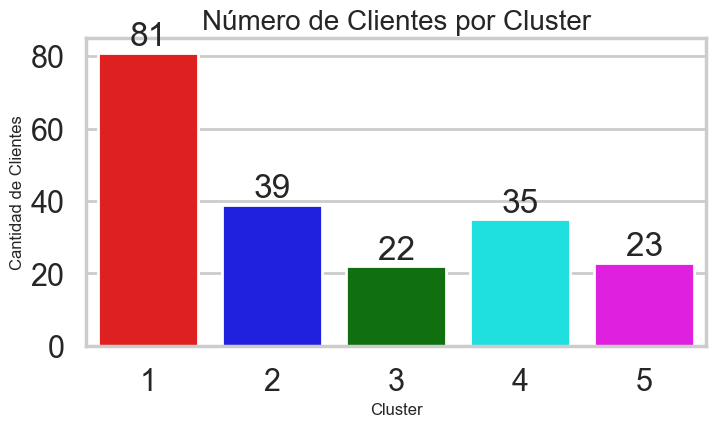

In [63]:
plt.figure(figsize=(8, 4))
datos_cluster = X_clustered.with_columns(pl.col('Cluster Pred').add(1).alias('Cluster Pred'))

sns.countplot(data=datos_cluster, 
              x='Cluster Pred',
              hue='Cluster Pred',  
              palette=['red', 'blue', 'green', 'cyan', 'magenta'],
              order=range(1, 6),
              legend=False)  

# Agregar los valores encima de cada barra
for i in plt.gca().containers:
    plt.gca().bar_label(i, label_type='edge')

plt.title('Número de Clientes por Cluster', fontsize=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.show()


# Análisis con escalamiento de las variables

Pasamos al escalamiento de las variables

El escalonamiento de variables en K-means se realiza para garantizar que todas las variables tengan una influencia equitativa en la formación de los clusters. Esto es especialmente importante cuando las variables tienen diferentes escalas o unidades de medida.


In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
X_scaled.shape
X_scaled[:5]

array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992]])

calculamos la suma de errores cuadrados (WSS) dentro del conglomerado para diferentes valores de k. A continuación, elegimos el k para el cual el WSS comienza a disminuir. Este valor de K nos proporciona el número óptimo de conglomerados para crear a partir de los datos sin procesar.

1. Ejecutar el algoritmo 10 veces: cuando K=1, K=2, … K=10
2. Calcularemos la suma de los cuadrados de cada clusters (WCSS)
3. Visualizaremos en un grafico cuando sucede ese cambio de tendencia mediante la gráfica del codo

In [46]:
wcss = []
n_clu = 10

for i in range(1, n_clu+1):

    kmeans = KMeans(n_clusters = i, 
                    init = "k-means++", 
                    max_iter = 300, 
                    n_init = 10, 
                    random_state = 42)

    kmeans.fit(X_scaled) 
    
    wcss.append(kmeans.inertia_)

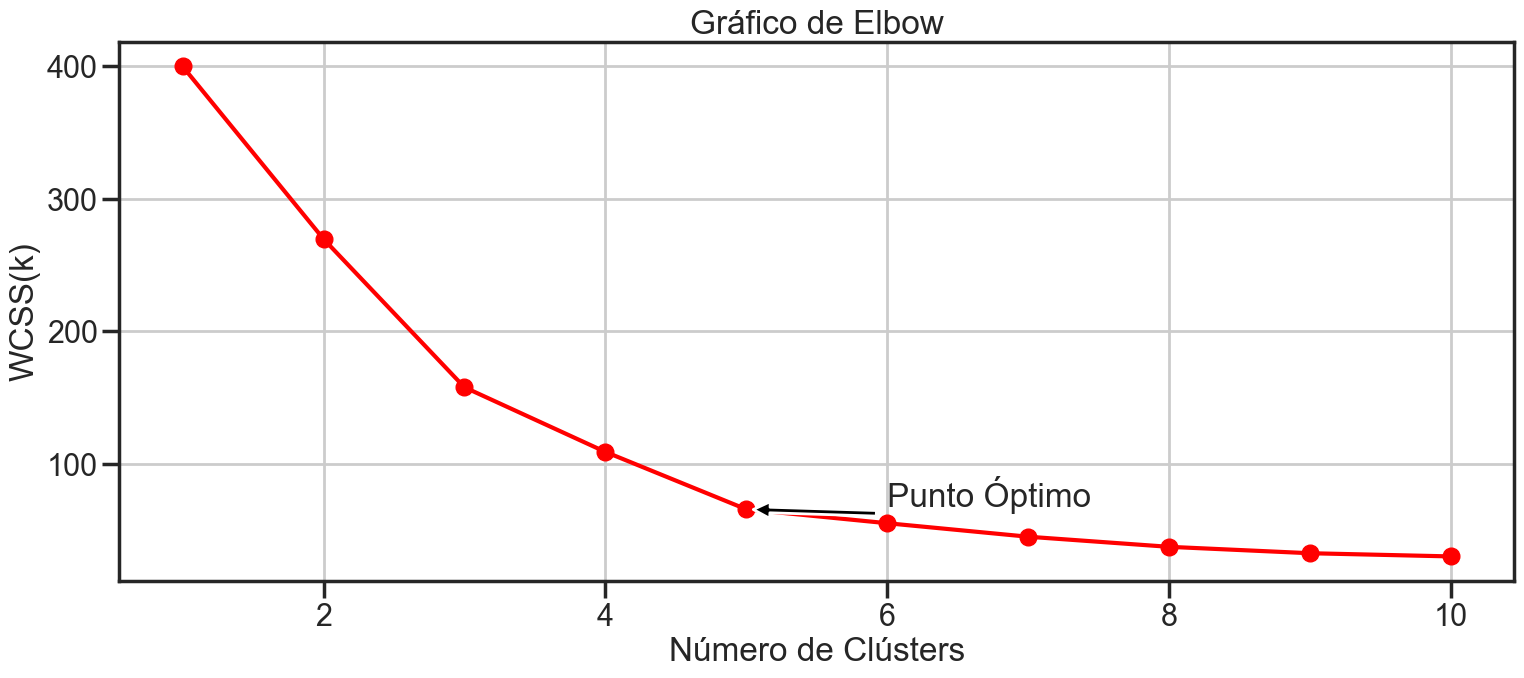

In [47]:
plt.plot(range(1,11), wcss, marker='o', color='red')
plt.title("Gráfico de Elbow")
plt.xlabel("Número de Clústers")
plt.ylabel("WCSS(k)")
plt.grid(True)

# Anotar el punto de codo para una mejor visualización
plt.annotate('Punto Óptimo', xy=(5, wcss[4]), 
             xytext=(6, wcss[4]+2),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)

In [48]:
kmeans = KMeans(n_clusters = 5, 
                init="k-means++", 
                max_iter = 100, 
                n_init = 10, 
                random_state = 42)
           
y_kmeans = kmeans.fit_predict(X)

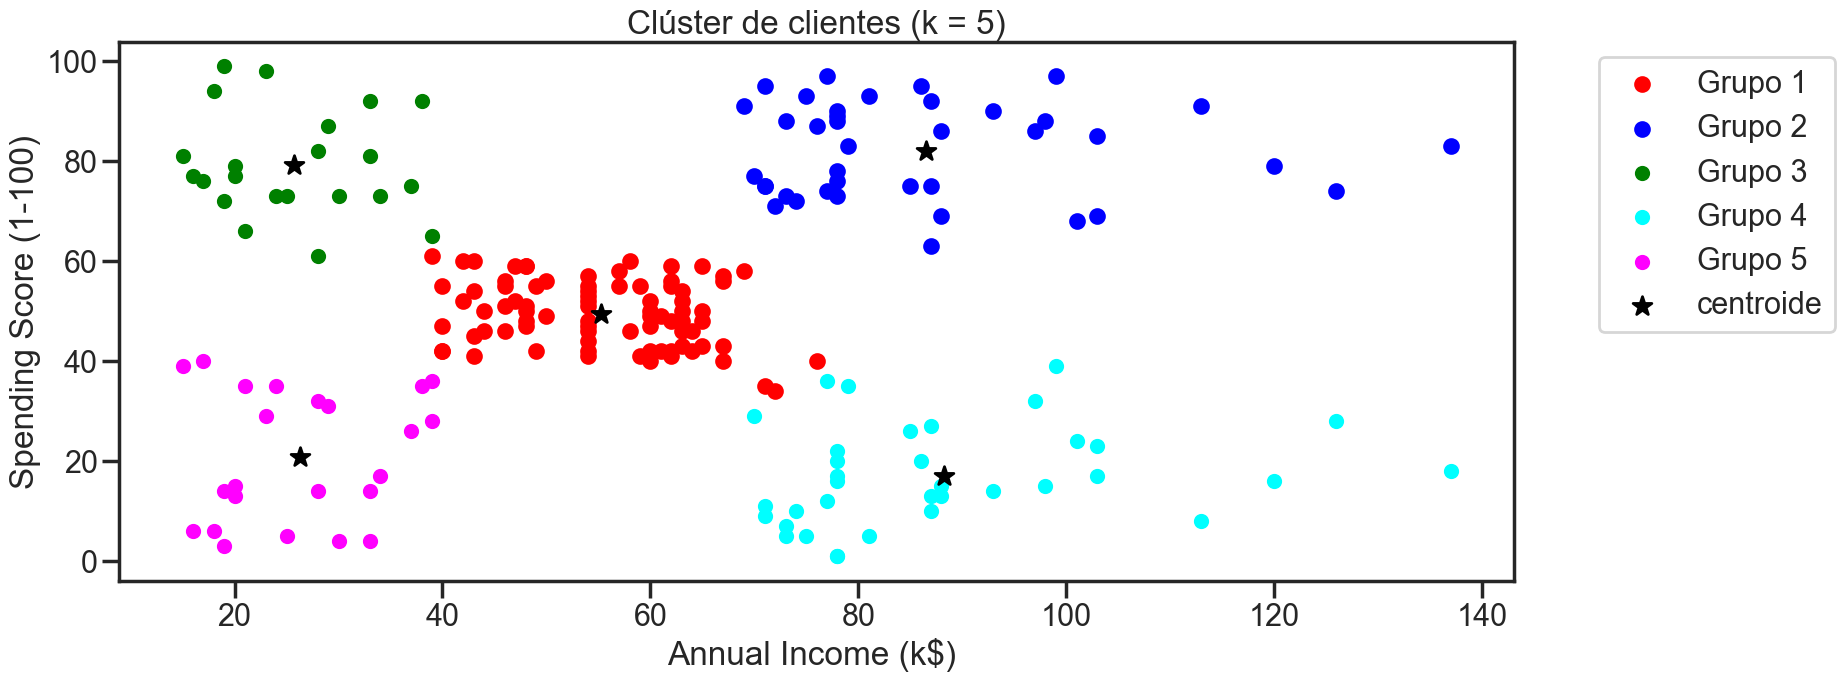

<Figure size 1000x800 with 0 Axes>

In [49]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], 
              s = 100, c = "red", label = "Grupo 1")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], 
              s = 100, c = "blue", label = "Grupo 2")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 80, 
              c = "green", label = "Grupo 3")
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 80, 
              c = "cyan", label = "Grupo 4")
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 80, 
              c = "magenta", label = "Grupo 5")

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
              s = 200, c = "black", label = "centroide", marker = '*')

plt.title('Clúster de clientes (k = 5)')
plt.xlabel('Annual Income (k$) ')
plt.ylabel('Spending Score (1-100)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(10, 8))
plt.show()

Al realizar el escalonamiento de las variables no se presenta ningun cambio en la eleccion de los clustres.

# Conclusiones

El análisis de segmentación de clientes ha aportado importantes insights que fortalecen la comprensión del comportamiento de los clientes y optimizan la estrategia comercial:

1. **Determinación del Número Óptimo de Segmentos:**
  - Tanto los análisis en 2D como en 3D coinciden en la identificación de 5 segmentos distintos, incluso luego de aplicar el escalonamiento de variables.
  - Los métodos del codo y del coeficiente de silueta confirmaron la elección de 5 clústeres, ya que se observa una disminución significativa en la variación intra-clúster a partir de este número.

2. **Caracterización de los Segmentos:**
  - **Grupo #2 (Objetivo):** Clientes con altos ingresos y alto gasto.
  - **Grupo #4 (Potencial):** Clientes con altos ingresos pero bajo gasto.
  - **Grupo #1 (Estable):** Clientes con ingresos y gasto en rangos promedio.
  - **Grupo #3 (Monitoreo Cuidadoso):** Clientes con bajos ingresos pero alto gasto.
  - **Grupo #5 (Básico):** Clientes con bajos ingresos y bajo gasto.

3. **Patrones Demográficos Relevantes:**
  - La distribución por género indica una mayor presencia de mujeres, lo que puede orientar estrategias de marketing específicas.
  - Se observa una amplia distribución etaria con representación significativa en distintos grupos de edad.
  - Los ingresos anuales tienden a concentrarse entre 50.000 y 85.000 dólares, lo que sugiere la predominancia de un segmento socioeconómico medio-alto.

4. **Relaciones entre Variables:**
  - La correlación entre edad y patrones de gasto es débil, mientras que existe una correlación moderada entre edad e ingresos.
  - Aunque no se observan relaciones directas entre ingresos y gasto, los patrones de agrupación permiten identificar segmentos diferenciados.

5. **Implicaciones y Estrategias Comerciales:**
  - La segmentación permite diseñar campañas de marketing dirigidas y estrategias de comunicación personalizadas.
  - Se pueden optimizar la oferta de productos y servicios en función de las características y necesidades de cada segmento.
  - La comprensión detallada de cada grupo facilita la implementación de acciones comerciales que incrementen la fidelización y satisfacción del cliente.

En resumen, la aplicación de técnicas de aprendizaje automático para la segmentación de clientes en centros comerciales ofrece un enfoque rentable para identificar oportunidades de negocio. Aunque el comportamiento del consumidor es dinámico, los resultados obtenidos proporcionan una base sólida para el diseño de estrategias comerciales más precisas y efectivas.
